In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.base import BaseEstimator, TransformerMixin
import string
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn import model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
with open('/content/drive/MyDrive/IR Project/Dataset/merged_training.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df['emotions'].value_counts()


joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64

In [ ]:
df

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [ ]:
#Dropping Surprise
df = df[df['emotions']!='surprise']

In [ ]:
df['emotions'].value_counts()

joy        141067
sadness    121187
anger       57317
fear        47712
love        34554
Name: emotions, dtype: int64

# Preprocessing

In [ ]:
#For text cleaning and preprocessing - reference taken from https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27

In [ ]:
class preprocess(BaseEstimator, TransformerMixin):
    def no_instanced(self, text_values):
        return re.sub(r'@\w+', '', text_values)
    
    def urls_delete(self, text_values):
        return re.sub(r'http.?://[^\s]+[\s]?', '', text_values)
    
    def process_emoticon(self, text_values):
        return text_values.replace('_','')
    
    def no_puntc(self, text_values):
        punctuation_words = string.punctuation
        punc_to_space = str.maketrans(punctuation_words, len(punctuation_words)*' ') 
        return text_values.translate(punc_to_space)
    
    def no_numerics(self, text_values):
        return re.sub('\d+', '', text_values)
    
    def convert_tolower(self, text_values):
        return text_values.lower()
    
    def no_stopwords(self, text_values):
        rm_stopwords = stopwords.words('english')
        blockwords = ["n't", "not", "no"]
        words = text_values.split() 
        clean_words = [word for word in words if (word not in rm_stopwords or word in blockwords) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.no_instanced).apply(self.urls_delete).apply(self.process_emoticon).apply(self.no_puntc).apply(self.no_numerics).apply(self.convert_tolower).apply(self.no_stopwords)
        return clean_X

In [ ]:
pp = preprocess()
cleaned_text = pp.fit_transform(df.text)

In [ ]:
cleaned_text

27383            feel awful job get position succeed happen
110083                                  im alone feel awful
140764    ive probably mentioned really feel proud actua...
100071                         feeling little low days back
2837      beleive much sensitive peoples feelings tend c...
                                ...                        
566       felt finally accepted bulgarian conservatorie ...
36236     take every day comes focussing eating better m...
76229                         suddenly feel everything fake
131640    im feeling eager ever claw back went pear shap...
64703     give plenty attention even feel utterly miserable
Name: text, Length: 401837, dtype: object

In [ ]:
cleaned_text.isnull().sum()

0

In [ ]:
#Lets see what are most frequently used words
vectors_counting = CountVectorizer()
BOW = vectors_counting.fit_transform(cleaned_text)
find_frequency = dict(zip(vectors_counting.get_feature_names(),np.asarray(BOW.sum(axis=0)).ravel()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


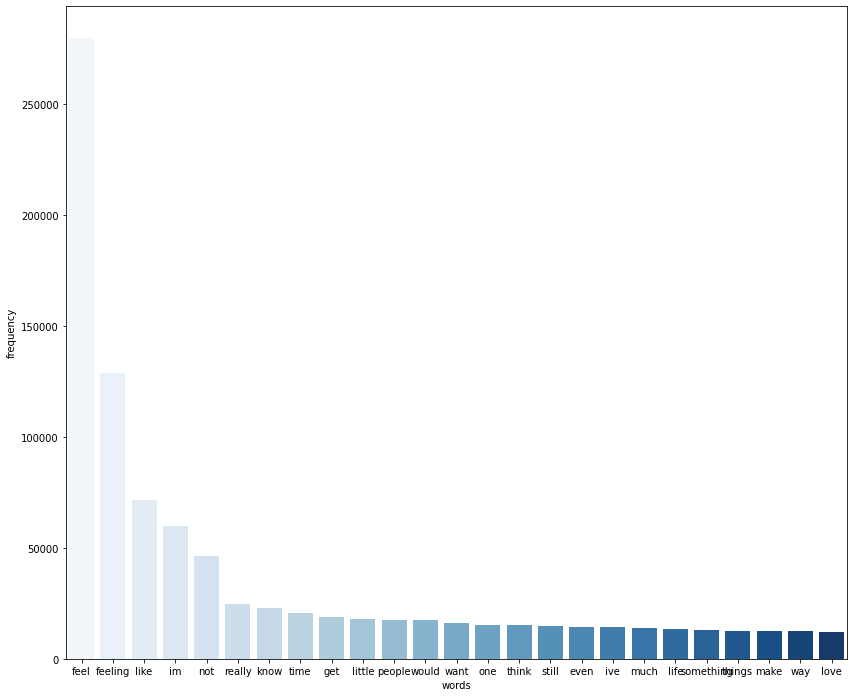

In [ ]:
# count = collections.Counter(find_frequency)
# count_dataframe = pd.DataFrame(count.most_common(25), columns = ['words', 'frequency'])
# fig, ax = plt.subplots(figsize=(14, 12))
# sns.barplot(x="words", y="frequency", data=count_dataframe, palette="Blues", ax=ax)
# plt.show();

In [ ]:
#Creating a test set

In [ ]:
dataframe_copy = df

In [ ]:
dataframe_copy['preprocessed_sentence'] = cleaned_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataframe_copy = dataframe_copy.drop(columns=['text'])

In [ ]:
dataframe_copy

,emotions,preprocessed_sentence
27383,sadness,feel awful job get position succeed happen
110083,sadness,im alone feel awful
140764,joy,ive probably mentioned really feel proud actua...
100071,sadness,feeling little low days back
2837,love,beleive much sensitive peoples feelings tend c...
...,...,...
566,joy,felt finally accepted bulgarian conservatorie ...
36236,fear,take every day comes focussing eating better m...
76229,sadness,suddenly feel everything fake
131640,joy,im feeling eager ever claw back went pear shap...


In [ ]:
dataframe_new=dataframe_copy.drop('emotions', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataframe_new, dataframe_copy.emotions, test_size=0.2, random_state=41)

In [ ]:
X_train

,preprocessed_sentence
17175,cant help feel amused reading
29573,feel vaguely dissatisfied recovery
9684,creep factor effectively emulated feel cold wa...
66745,feel everything precious started fade away esp...
97737,loved way friendship springs romance realized ...
...,...
25170,guess im trying say feeling overwhelmed bites
9567,starting feel like sitting much less sitting c...
11783,feel like ive running around without sense dir...
60910,feel disturbed recent experiences believe open...


## Converting Word to Vectors

In [ ]:
X_train['splitted_words'] = X_train.preprocessed_sentence.apply(lambda x : word_tokenize(x))
X_test['splitted_words'] = X_test.preprocessed_sentence.apply(lambda x : word_tokenize(x))


In [ ]:
X_train

,preprocessed_sentence,splitted_words
17175,cant help feel amused reading,"[cant, help, feel, amused, reading]"
29573,feel vaguely dissatisfied recovery,"[feel, vaguely, dissatisfied, recovery]"
9684,creep factor effectively emulated feel cold wa...,"[creep, factor, effectively, emulated, feel, c..."
66745,feel everything precious started fade away esp...,"[feel, everything, precious, started, fade, aw..."
97737,loved way friendship springs romance realized ...,"[loved, way, friendship, springs, romance, rea..."
...,...,...
25170,guess im trying say feeling overwhelmed bites,"[guess, im, trying, say, feeling, overwhelmed,..."
9567,starting feel like sitting much less sitting c...,"[starting, feel, like, sitting, much, less, si..."
11783,feel like ive running around without sense dir...,"[feel, like, ive, running, around, without, se..."
60910,feel disturbed recent experiences believe open...,"[feel, disturbed, recent, experiences, believe..."


In [ ]:
model = gensim.models.Word2Vec(X_train.splitted_words, min_count=1, size=50, window=5, workers=4)


In [ ]:
def calculate_avg_word_2_vec(dictionary, sentences):
    list_of_word_vectors = [dictionary[w] for w in sentences if w in dictionary.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*50
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result


In [ ]:
word_to_vec_Xtrain = X_train['splitted_words'].apply(lambda x: calculate_avg_word_2_vec(model.wv, x))
word_to_vec_Xtest = X_test['splitted_words'].apply(lambda x: calculate_avg_word_2_vec(model.wv, x))

In [ ]:
word_to_vec_Xtrain = pd.DataFrame(word_to_vec_Xtrain.values.tolist(), index= X_train.index)
word_to_vec_Xtest = pd.DataFrame(word_to_vec_Xtest.values.tolist(), index= X_test.index)


In [ ]:
word_to_vec_Xtrain = pd.concat([word_to_vec_Xtrain, X_train.drop(['preprocessed_sentence', 'splitted_words'], axis=1)], axis=1)
word_to_vec_Xtest = pd.concat([word_to_vec_Xtest, X_test.drop(['preprocessed_sentence', 'splitted_words'], axis=1)], axis=1)

In [ ]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [ ]:
import joblib

In [ ]:
model_logreg = LogisticRegression(max_iter = 1000)

model_logreg.fit(word_to_vec_Xtrain,y_train)
joblib.dump(model_logreg, 'model_logreg.pkl')

model_logreg = joblib.load('model_logreg.pkl')
predictions = model_logreg.predict(word_to_vec_Xtest)

print("Accuracy: ",accuracy_score(predictions, y_test)*100)

Accuracy:  65.75378260003981


In [ ]:
report = classification_report(y_test, predictions, output_dict=True)
c1 = pd.DataFrame(report).transpose()
c1

,precision,recall,f1-score,support
0,0.597922,0.423280,0.495668,11555.000000
1,0.631150,0.453278,0.527626,9396.000000
2,0.717989,0.845277,0.776451,28147.000000
3,0.539743,0.282044,0.370488,7006.000000
4,0.625899,0.738831,0.677693,24264.000000
accuracy,0.657538,0.657538,0.657538,0.657538
macro avg,0.622541,0.548542,0.569585,80368.000000
weighted avg,0.647232,0.657538,0.641785,80368.000000


In [ ]:
model_ranfor = RandomForestClassifier()

model_ranfor.fit(word_to_vec_Xtrain,y_train)
joblib.dump(model_ranfor, 'model_ranfor.pkl')

model_ranfor = joblib.load('model_ranfor.pkl')
predictions = model_ranfor.predict(word_to_vec_Xtest)

print("Accuracy: ",accuracy_score(predictions, y_test)*100)

Accuracy:  61.243280907824


In [ ]:
report = classification_report(y_test, predictions, output_dict=True)
c2 = pd.DataFrame(report).transpose()
c2

,precision,recall,f1-score,support
0,0.613211,0.306101,0.408359,11555.000000
1,0.633032,0.275756,0.384165,9396.000000
2,0.651757,0.833481,0.731502,28147.000000
3,0.362799,0.151727,0.213969,7006.000000
4,0.587961,0.765290,0.665007,24264.000000
accuracy,0.612433,0.612433,0.612433,0.612433
macro avg,0.569752,0.466471,0.480600,80368.000000
weighted avg,0.599576,0.612433,0.579243,80368.000000


In [ ]:
clf = DecisionTreeClassifier(random_state=0)

clf.fit(word_to_vec_Xtrain, y_train)
joblib.dump(clf, 'clf.pkl')

clf = joblib.load('clf.pkl')
y_pred=clf.predict(word_to_vec_Xtest)

accuracy_score(y_pred,y_test)

0.45546735018913

In [ ]:
report = classification_report(y_test, predictions, output_dict=True)
c3 = pd.DataFrame(report).transpose()
c3

,precision,recall,f1-score,support
0,0.613211,0.306101,0.408359,11555.000000
1,0.633032,0.275756,0.384165,9396.000000
2,0.651757,0.833481,0.731502,28147.000000
3,0.362799,0.151727,0.213969,7006.000000
4,0.587961,0.765290,0.665007,24264.000000
accuracy,0.612433,0.612433,0.612433,0.612433
macro avg,0.569752,0.466471,0.480600,80368.000000
weighted avg,0.599576,0.612433,0.579243,80368.000000
